# Continuous RL - Advantage Actor Critic (A2C)

In [1]:
import random
import os
import numpy as np
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
from utils import plot_cost_to_go , plot_max_q , test_agent , plot_stats , seed_everything , plot_action_probs , test_policy_network
from parallel_env import ParallelEnv , ParallelWrapper
%matplotlib notebook

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Ali\Documents\RLwithPhil\code\parallel_env.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool: ctypes.c_bool}


In [2]:
env = gym.make('Acrobot-v1')

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"state dim: {state_dims}, action dim: {num_actions}")

state dim: 6, action dim: 3


In [4]:
## Parallelize Environment
num_envs = int(os.cpu_count() / 2)
print(f"Max num_envs : {num_envs}")

Max num_envs : 8


In [5]:
def create_env(env_name , seed):
    env = gym.make(env_name)
    seed_everything(env , seed = seed)
    return env

In [6]:
env_fns = [lambda: create_env('Acrobot-v1',rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [7]:
parallel_env.reset() # num_envs x 6 states

array([[ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856],
       [ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856],
       [ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856],
       [ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856],
       [ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856],
       [ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856],
       [ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856],
       [ 0.999687  ,  0.02501648,  0.9968461 ,  0.07935923,  0.05513714,
        -0.05495856]], dtype=float32)

In [8]:
class PreprocessEnv(ParallelWrapper): ## to be able to work with pyTorch library
    def __init__(self , parallel_env ):
        ParallelWrapper.__init__(self, parallel_env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self , actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
        
    def step_wait(self):
        next_state , reward , done , info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state , reward , done , info

In [9]:
parallel_env = PreprocessEnv(parallel_env )

In [10]:
parallel_env.reset()

tensor([[ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642],
        [ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642],
        [ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642],
        [ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642],
        [ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642],
        [ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642],
        [ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642],
        [ 0.9992, -0.0400,  0.9972,  0.0746, -0.0989,  0.0642]])

In [11]:
a , b , _ , _ = parallel_env.step(torch.zeros(num_envs,1 , dtype = torch.int32))
a.shape

torch.Size([8, 6])

In [12]:
# Policy Network
policy = nn.Sequential(
    nn.Linear(state_dims , 128),
    nn.ReLU(),
    nn.Linear(128 , 64),
    nn.ReLU(),
    nn.Linear(64,num_actions),
    nn.Softmax(dim=-1))

policy

Sequential(
  (0): Linear(in_features=6, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
  (5): Softmax(dim=-1)
)

In [13]:
# Value Network
value_net = nn.Sequential(
    nn.Linear(state_dims , 128),
    nn.ReLU(),
    nn.Linear(128 , 64),
    nn.ReLU(),
    nn.Linear(64,1))
value_net

Sequential(
  (0): Linear(in_features=6, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
def A2C(policy , value_net , episodes , alpha = 1e-4 , gamma=0.99 , beta = 1e-2):
    policy_optim = AdamW(policy.parameters() , lr = alpha)
    value_optim = AdamW(value_net.parameters() , lr = alpha)
    
    stats = {'Actor Loss' : [] , 'Critic Loss' : [] ,'Returns':[]}
    
    for episode in tqdm(range(1 , episodes+1) ) :
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs , 1),dtype=torch.bool)
        ep_return= torch.zeros((num_envs , 1))
        I=1
        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state , reward , done , _ = parallel_env.step(action)
            
            value = value_net(state)
            target = reward + torch.logical_not(done) * gamma * (value_net(next_state).detach()) 
            # because we want to calculate loss based on the present estimate v(St|w) not v(St+1|w)
            
            critic_loss = F.mse_loss(value , target)
            value_net.zero_grad()
            critic_loss.backward()
            value_optim.step()
            
            adv = (target-value).detach()
            probs = policy(state)
            log_probs = torch.log(probs+1e-7)
            action_log_probs = log_probs.gather(1,action)
            
            entropy = - torch.sum(probs * log_probs ,dim=-1 , keepdim=True)
            actor_loss = -(I*action_log_probs*adv + beta * entropy)
            actor_loss = actor_loss.mean()
            
            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()
            
            ep_return += reward
            done_b |= done
            state=next_state
            I = I * gamma
    
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())
    return stats     

In [15]:
stats = A2C(policy , value_net , 200 )

100%|█████████████████████████████████████████████████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


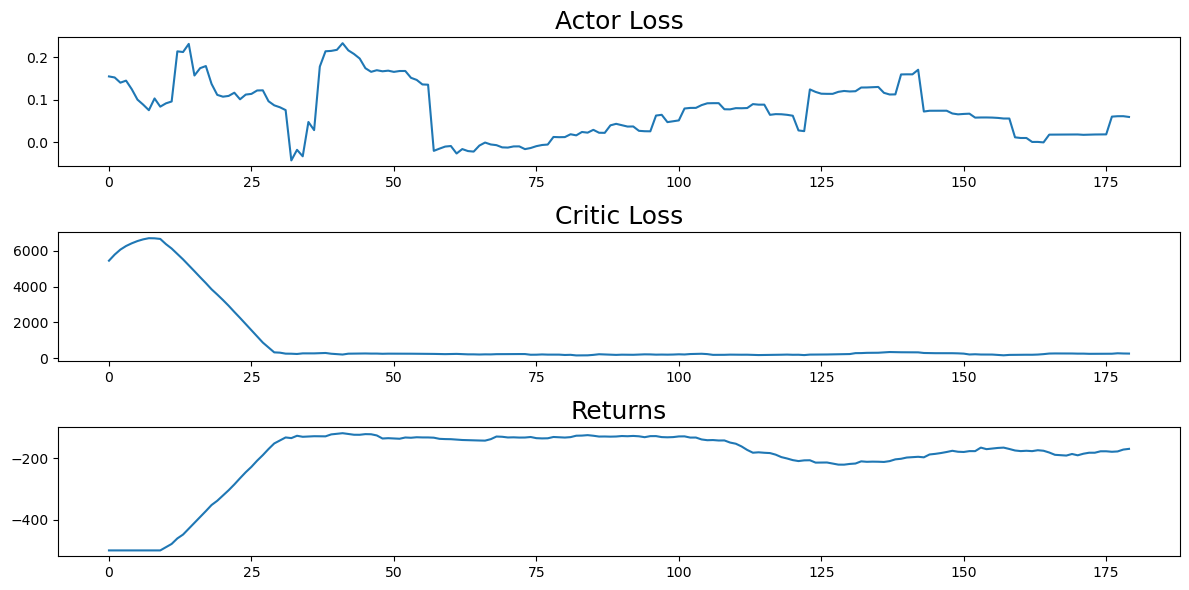

In [18]:
plot_stats(stats)

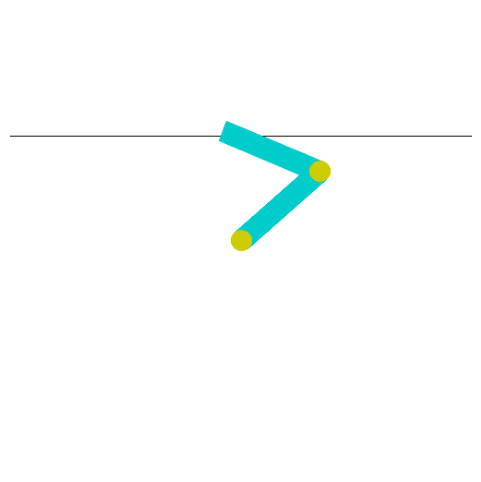

In [19]:
%matplotlib inline
test_policy_network(env , policy , 3)